# So, I've Been Playing...
... some Hunt:Showdown recently which is a sort of mixture of Battle Royale, Extraction Shooters and gunplay somewhere closer to a Tactical Shooter than an Arcade shooter. What I can say is that the game is challenging and fun without getting too competitve. There are players which are like that but most of the games are simply fun.

At this point, I've played just shy of 500 hours and thought it was about to time to start playing around with the data in the game.

## Where is the Data?
Surprisingly, there is no public dataset outside of a wiki containing all the data for the guns in the game. Naturally, I set about recoding all that data into a spreadsheet which I'll be sharing once it is done; this is tedious work but sometimes we have to make our own datasets the hard way.

I've only made it through what are called the **Small Slot** weapons so far. How this works is that Guns take up a kind of weight block and you can carry up to 4 blocks worth of weapons. These slots go from 1 to 3 blocks and so most players are running a 3-1 set of weapons. But, that is enough to start playing around with the data!

## Leading Questions
Some initial questions I had about the data would be:
1. How the features of guns would affect the price?
2. What are the most common Muzzle Velocities at this level?
3. What is the spread of damage fall off for Small Slot weapons?

We'll look the Linear Model last since there were complications with it.

## Let's Check Out The Data!
We'll get our normal imports for this kind of work.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pathlib import Path

# Don't forget to install openpyxl otherwise you will get an import error.

In [4]:
#| echo: false
dataDirectory = Path("../../_drafts/_data")
filename = 'Hunt_Status.xlsx'


I'm using Microsoft Excel via the Web to input the data and there is no option to simply download a CSV file. So, we'll need to tell our function which sheet we'll want. By default, it will use the first sheet if you do not specify but I'm using that page for some overview information and summary of insights.

In [41]:
data = pd.read_excel(dataDirectory/filename, sheet_name='Stats', na_values='N/a')
data.head(10)

,Weapon,Slot,Cost,Damage,Muzzle Velocity,Falloff 10m,Falloff 25m,Falloff 50m,Falloff 75m,Ammo Type,...,Rate of Fire,Cycle Time,Spread,Sway,Vertical Recoil,Reload Speed,Melee Damage,Melee Damage Heavy,Stamina Consumption Light,Stamina Consumption Heavy
0,Machete,Small,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,90,150,10.0,20
1,Nagant M1895,Small,24,91.0,330.0,91.0,83.0,48.0,31.0,Compact,...,21.0,1.5,40.0,128.0,4.0,12.5,13,31,NaN,20
2,Nagant M1895,Small,74,91.0,330.0,91.0,83.0,48.0,31.0,Poison,...,21.0,1.5,40.0,128.0,4.0,12.5,13,31,NaN,20
3,Nagant M1895,Small,84,91.0,490.0,91.0,83.0,48.0,31.0,High Velocity,...,21.0,1.5,40.0,128.0,6.0,12.5,13,31,NaN,20
4,Hand Crossbow,Small,30,195.0,100.0,150.0,128.0,NaN,NaN,Special,...,14.0,4.5,25.0,82.0,1.2,4.3,13,27,NaN,10
5,Cadwell Conversion Pistol,Small,55,104.0,300.0,104.0,94.0,54.0,36.0,Compact,...,21.0,1.4,30.0,128.0,4.5,11.2,13,31,NaN,20
6,Cadwell Conversion Pistol,Small,105,104.0,300.0,104.0,94.0,54.0,36.0,Dum Dum,...,21.0,1.4,30.0,128.0,4.5,11.2,13,31,NaN,20
7,Cadwell Conversion Pistol,Small,105,104.0,270.0,104.0,104.0,71.0,46.0,Full Metal Jacket,...,21.0,1.4,30.0,128.0,4.5,11.2,13,31,NaN,20
8,Cavalry Saber,Small,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82,168,10.0,17
9,Scottfield Model 3,Small,77,107.0,280.0,107.0,101.0,65.0,44.0,Medium,...,24.0,1.5,28.1,128.0,9.0,9.0,13,31,NaN,20


We'll need to do some conversions since most of the columns came in correct but we would like a few columns to be categorical type for later. This is simple and it's been done before:

In [42]:
data = data.assign(
    Slot = data.Slot.astype('category'),
    Type = data['Ammo Type'].astype('category'),
    Addendum = data['Addendum Bullet'].astype('bool')
).drop(
    ['Ammo Type', 'Addendum Bullet'],
    axis=1
)

data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Weapon                     66 non-null     object  
 1   Slot                       66 non-null     category
 2   Cost                       66 non-null     int64   
 3   Damage                     64 non-null     float64 
 4   Muzzle Velocity            64 non-null     float64 
 5   Falloff 10m                64 non-null     float64 
 6   Falloff 25m                64 non-null     float64 
 7   Falloff 50m                63 non-null     float64 
 8   Falloff 75m                63 non-null     float64 
 9   Barrel Count               64 non-null     float64 
 10  Total Ammo                 64 non-null     float64 
 11  Sighted Range              1 non-null      float64 
 12  Effective Range            63 non-null     float64 
 13  Rate of Fire               64 non-nul

### GRAPHS!
Our real focus is talking about the cost of guns so what does the spread of costs look like?:

In [31]:
# some plot configs I like
pal = sns.dark_palette("seagreen", n_colors=10)
plt.rcParams["figure.figsize"] = (14,7);

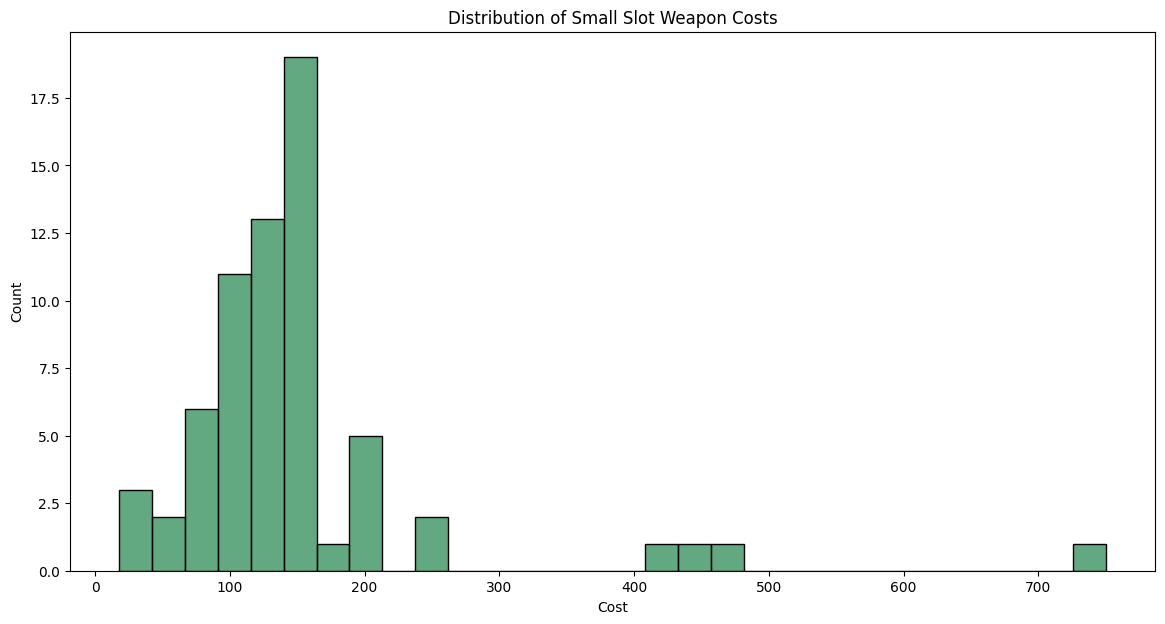

In [21]:
sns.histplot(data, x='Cost', color='seagreen').set_title("Distribution of Small Slot Weapon Costs");

There are a few outliers we'll need to keep in mind but it's not clear where the center is. Maybe somewhere around $150?
Let's actually calculate it out:

In [24]:
print(f'The mean cost of a small slot weapon is ${round(data.Cost.mean(), 2)} and the median is ${round(data.Cost.median(), 2)}')

The mean cost of a small slot weapon is $152.47 and the median is $135.0


Those numbers do make sense with the graph - including the outliers which have sway to the right. Again, we'll need to deal with those later but for now they will be overlooked.

Next we will check out *Muzzle Velocity* but this requires a bit of explanation. In Hunt, different guns have different bullet speeds. When taking and shooting guns, the bullets have travel time and so you **must lead moving targets**. And, how much you need to lead depends on the distance to the target as well as how fast you bullet travels.

Most guns in the *Small Slot* have very low *Muzzle Velocities* so hitting moving targets can be difficult. Let us figure out what what the distribution is here:

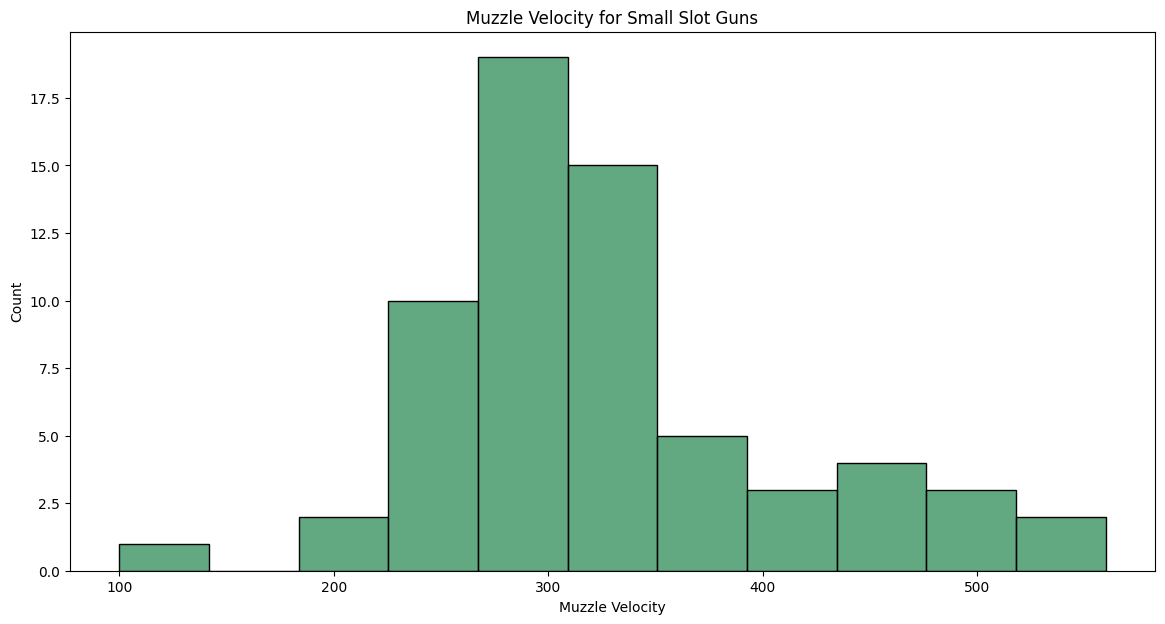

In [26]:
sns.histplot(data, x='Muzzle Velocity', color='seagreen').set_title("Muzzle Velocity for Small Slot Guns");

In [29]:
print(f'The mean muzzle velocity of a small slot weapon is {round(data["Muzzle Velocity"].mean(), 2)} m/s and the median is {round(data["Muzzle Velocity"].median(), 2)} m/s')

The mean muzzle velocity of a small slot weapon is 325.33 m/s and the median is 315.0 m/s


Those are some pretty terrible muzzle velocities as we'll see when we get to the 3 block weapons. As an example, some of the higher velocity bullets can get upwards of 800m/s. Shooting pistols in this game is very limited to close quarters: mostly.

Next we'll look at how the number of bullets in the barrel compares to how often you can shoot the gun: aka *Cycle Time*. My prediction is that the less bullets there are the faster you can them while the larger the barrel then the slower.

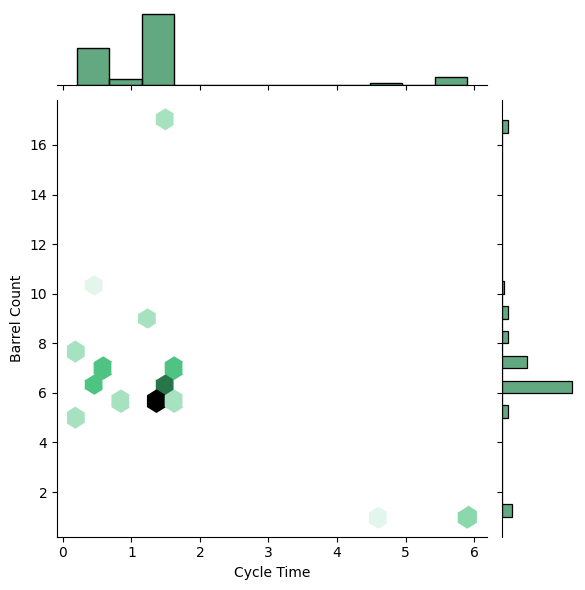

In [32]:
# This isn't what I expected; looks really binary here.
sns.jointplot(data, y='Barrel Count', x='Cycle Time', kind='hex', color='seagreen');

I was simply wrong.
Most of the values are clustered around the same area with just a few outliers. Not a lot of variety here so this is likely some kind of balancing problem. Maybe not necessarily around these two attributes but around others and these two get tuned?
Let's quickly check out what those outlier weapons are:

In [37]:
# These are the outliers but they're not really run more commonly than the other guns in my experience.
# Except the Dolch really; it's the stable High MMR pistol
for i, weapon in enumerate(data[ (data['Barrel Count'] > 9)  | (data['Cycle Time'] > 4)].Weapon.unique().tolist()):
    print(f'{i+1}. {weapon}')

1. Hand Crossbow
2. Cadwell Conversion Chain Pistol
3. Sparks Pistol
4. Dolch 96


Special ammo, Prototype ammo, a Long Ammo and a ton of Compact ammo. All of these lean into a special feature about them. Honestly, I am surprised the Uppercut is not in the list.

Next, I want to check out how much variability there is in the muzzle velocity by type of ammo:

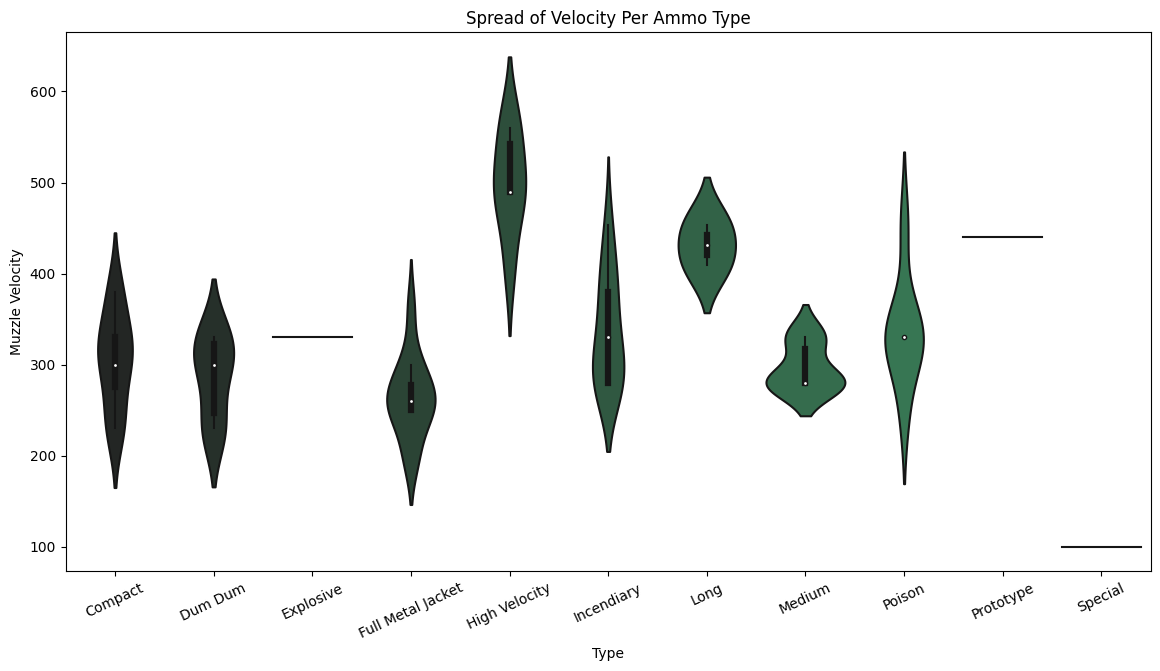

In [47]:
plt.xticks(rotation=25);
sns.violinplot(data, x='Type', y='Muzzle Velocity', palette=pal).set_title("Spread of Velocity Per Ammo Type");

What's cool here is that it shows how the lower Muzzle Velocity doesn't hurt much when running FMJ. Honestly, unless you have a reason to run a different ammo type there is little reason not to just throw some Full Metal Jackets (FMJ) on the Small Slot Guns; it is almost always a safe choice. 

Lastly, I just wanted to review how much damage is lost due to fall off in the *Small Slot* weapons. It took a lot of testing and a lot of bought guns but I did get that data. And, wow do these guns fall off really hard. You lose a lot of damage quickly considering how small a distance between 25 and 50 meters in this game and how many gun fights take place around this range.
![](images/2023-08-14/35maway.png)

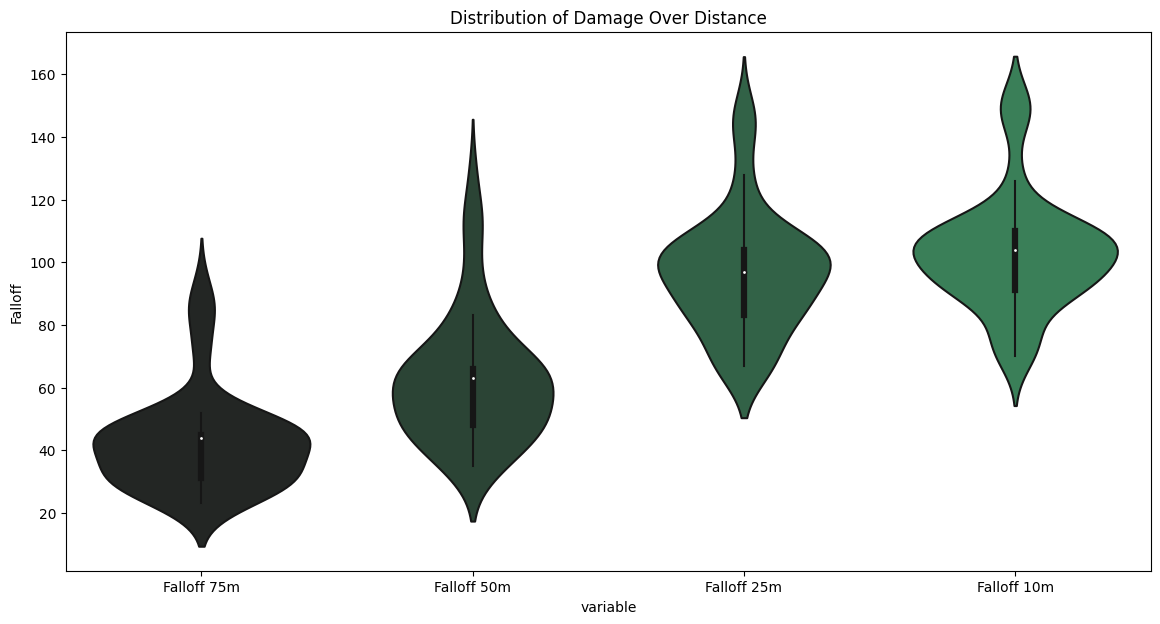

In [51]:
pal = sns.dark_palette("seagreen", n_colors=4)
tmp = data.melt(id_vars=['Weapon', 'Type'], value_vars=['Falloff 75m', 'Falloff 50m', 'Falloff 25m', 'Falloff 10m'], value_name='Falloff')
sns.violinplot(tmp, x='variable', y='Falloff', palette=pal).set_title("Distribution of Damage Over Distance");

As you can see from the Violin Plots, the longest range to the left has a mean less than half of what the shortest range to the right. The distribution is also quite squished so most of the values end up falling to around the same amount of damage regardless of which gun you pick. This makes it clear that these guns are all terrible at longer ranges - which is what Compact is supposed to be like.

## Linear Model of the Cost of Small Slot Guns
The time has come! Let's use a linear model to see how much different attributes affect the cost of each gun. This isn't the first post about this so we'll just move along to the code.

In [56]:
# Model Time!
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

There are melee weapons among the Small Slot weapons which we'll need to remove and we'll limit the categories to the primary attributes. The fastest way to remove the melee weapons is to drop them based on the `Rate of Fire` column as I filled them out as `N/a` while filling them out. We'll split the data apart as per normal:

In [57]:
lm = LinearRegression()

# Drop the melee weapons:
dataDropped = data.loc[ ~data['Rate of Fire'].isna() ]
Y,X = dataDropped['Cost'],dataDropped[['Damage', 'Total Ammo', 'Rate of Fire', 'Cycle Time', 'Type']]

Since there are categorical values, we will convert them to Dummy Values. Basically, this explodes the categorical column into lots of different columns with 1 values signifying if the categorical value is present. This is easier to see rather than explain:


In [59]:
Xt = pd.get_dummies(data=X)
Xt.head(15)

,Damage,Total Ammo,Rate of Fire,Cycle Time,Type_Compact,Type_Dum Dum,Type_Explosive,Type_Full Metal Jacket,Type_High Velocity,Type_Incendiary,Type_Long,Type_Medium,Type_Poison,Type_Prototype,Type_Special
1,91.0,28.0,21.0,1.5,1,0,0,0,0,0,0,0,0,0,0
2,91.0,28.0,21.0,1.5,0,0,0,0,0,0,0,0,1,0,0
3,91.0,28.0,21.0,1.5,0,0,0,0,1,0,0,0,0,0,0
4,195.0,19.0,14.0,4.5,0,0,0,0,0,0,0,0,0,0,1
5,104.0,24.0,21.0,1.4,1,0,0,0,0,0,0,0,0,0,0
6,104.0,24.0,21.0,1.4,0,1,0,0,0,0,0,0,0,0,0
7,104.0,24.0,21.0,1.4,0,0,0,1,0,0,0,0,0,0,0
9,107.0,18.0,24.0,1.5,0,0,0,0,0,0,0,1,0,0,0
10,107.0,18.0,24.0,1.5,0,0,0,0,0,1,0,0,0,0,0
11,107.0,18.0,24.0,1.5,0,0,0,1,0,0,0,0,0,0,0


Sadly, this method does enforce the training/test methodology which is normally correct but unnecessary in this example. 

In [61]:


# # Get dummies for categories:

X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.01, random_state=101)

lm.fit(X_train, y_train)
lm.intercept_, list(zip(Xt.columns, map(lambda x: round(x, ndigits=2), lm.coef_,)))

(-42.90337344119811,
 [('Damage', 2.66),
  ('Total Ammo', -1.95),
  ('Rate of Fire', 1.93),
  ('Cycle Time', -21.58),
  ('Type_Compact', -98.79),
  ('Type_Dum Dum', -80.83),
  ('Type_Explosive', 352.3),
  ('Type_Full Metal Jacket', -72.78),
  ('Type_High Velocity', -28.8),
  ('Type_Incendiary', -37.47),
  ('Type_Long', 43.81),
  ('Type_Medium', -136.32),
  ('Type_Poison', -61.14),
  ('Type_Prototype', 458.68),
  ('Type_Special', -338.67)])

Uh oh: Negative Intercept. Depending on what we're modeling, this is not *necessarily* incorrect but in our case this does not make much sense. Something is causing serious problems for the model and it is likely the Long Ammo - specifically the Uppercut. I'm going to remove this and it's variants so that this model actaully makes sense.

I think we're going to remove the long ammo.
Negative intercepts are a problem but they're likely due to the Long Ammo having such a strong impact on the model and try again.

In [62]:
# Get rid of the Uppercut
dataUppercutDropped = data.loc[ ~(data.Weapon == "Caldwell Conversion Uppercut")]
# Drop the melee weapons:
dataDropped = dataUppercutDropped.loc[ ~dataUppercutDropped['Rate of Fire'].isna() ]

Y,X = dataDropped['Cost'],dataDropped[['Damage', 'Total Ammo', 'Rate of Fire', 'Cycle Time', 'Type']]

# # Get dummies for categories:
Xt = pd.get_dummies(data=X) # , drop_first=True

X_train, X_test, y_train, y_test = train_test_split(Xt, Y, test_size=0.01, random_state=101)

lm.fit(X_train, y_train)
lm.intercept_, list(zip(Xt.columns, map(lambda x: round(x, ndigits=2), lm.coef_,)))

(239.65496894695224,
 [('Damage', -0.85),
  ('Total Ammo', -2.32),
  ('Rate of Fire', 1.7),
  ('Cycle Time', 21.09),
  ('Type_Compact', -79.91),
  ('Type_Dum Dum', -32.44),
  ('Type_Explosive', 0.0),
  ('Type_Full Metal Jacket', -31.13),
  ('Type_High Velocity', -27.16),
  ('Type_Incendiary', -35.93),
  ('Type_Long', -66.82),
  ('Type_Medium', -85.13),
  ('Type_Poison', -44.0),
  ('Type_Prototype', 521.69),
  ('Type_Special', -119.17)])

This is more sane. Looking at the numbers, we'd expect a discount of about $80 if we take a gun with compact ammo. That is about right but something is still wrong here. And, the reason is likely the Dolch 96 since this is a very heavy outlier.
I'm going to leave this analysis for today; a few steps would be to check out the residuals and try to remove the Dolch.
It could also be that this model simply is not linear in nature and a quadratic fit would be better.

The model is not wrong though; If we take compact ammo as an example then we'd expect a discount of about $80 and if we took poison then it would be a discount of about $45 off the price instead.